In [36]:
import sqlite3
import pandas as pd

con = sqlite3.connect("data/database.sqlite")

In [37]:
# country_id="21518" and league_id="21518" define La Liga
# id="43040" or team_api_id="8633" define Real Madrid
# id="43039" or team_api_id="9783" define RC Deportivo de La Coruña (opponent of Real Madrid in stage 38)
df = pd.read_sql_query('SELECT stage, date, home_team_goal, away_team_goal, '
                       'home_team_api_id, away_team_api_id, '
                       'B365H, B365D, B365A '
                       'FROM Match '
                       'WHERE country_id="21518" '
                       'AND league_id="21518" '
                       'ORDER BY season, stage ASC', con)

In [38]:
team = 8633

In [39]:
teams = df['home_team_api_id'].unique()
points = {}
clashes = {}
for team_id in teams:
    points[team_id] = {}
    clashes[team_id] = {}
    for team_id_inner in teams:
        if team_id != team_id_inner:
            points[team_id][team_id_inner] = []
            clashes[team_id][team_id_inner] = 0
for i, value in enumerate(df.values):
    home_team_api_id = df['home_team_api_id'].values[i]
    away_team_api_id = df['away_team_api_id'].values[i]
    home_team_goal = df['home_team_goal'].values[i]
    away_team_goal = df['away_team_goal'].values[i]
    if home_team_goal > away_team_goal:
        points[home_team_api_id][away_team_api_id].append(3)
        points[away_team_api_id][home_team_api_id].append(0)
    elif home_team_goal < away_team_goal:
        points[home_team_api_id][away_team_api_id].append(0)
        points[away_team_api_id][home_team_api_id].append(3)
    else:
        points[home_team_api_id][away_team_api_id].append(1)
        points[away_team_api_id][home_team_api_id].append(1)


In [40]:
bets_of_team = []
enemies_of_team = []
wins_of_team_in_last_five = []
for i, value in enumerate(df.values):
    home_team_api_id = df['home_team_api_id'].values[i]
    away_team_api_id = df['away_team_api_id'].values[i]
    if home_team_api_id == team:
        enemies_of_team.append(df['away_team_api_id'].values[i])
        bets_of_team.append(df['B365H'].values[i])
        wins = 0
        for j in range(clashes[home_team_api_id][away_team_api_id] - 5, clashes[home_team_api_id][away_team_api_id]):
            if j >= 0 and points[home_team_api_id][away_team_api_id][j] == 3:
                wins += 1
        wins_of_team_in_last_five.append(wins)
        clashes[home_team_api_id][away_team_api_id] += 1
        clashes[away_team_api_id][home_team_api_id] += 1
    if away_team_api_id == team:
        enemies_of_team.append(df['home_team_api_id'].values[i])
        bets_of_team.append(df['B365A'].values[i])
        wins = 0
        for j in range(clashes[away_team_api_id][home_team_api_id] - 5, clashes[away_team_api_id][home_team_api_id]):
            if j >= 0 and points[away_team_api_id][home_team_api_id][j] == 3:
                wins += 1
        wins_of_team_in_last_five.append(wins)
        clashes[home_team_api_id][away_team_api_id] += 1
        clashes[away_team_api_id][home_team_api_id] += 1

In [41]:
import pymc3 as pm
import arviz as az

class GaussianModel:
    def __init__(self, wins_team, bets):
        self.wins_team = wins_team
        self.bets = bets


    def run(self):
        basic_model = pm.Model()
        with basic_model:
            p_wins_team = pm.Normal("p_wins_team", mu=0, sigma=1)
            offset = pm.Normal("offset", mu=0, sigma=1)
            mu = p_wins_team * self.wins_team +\
                 offset
            pm.Normal("bets", mu=mu, sigma=1, observed=self.bets)
            self.trace = pm.sample(2000, tune=1000)
            az.plot_trace(self.trace, show=True)
            print(az.summary(self.trace, round_to=2))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [offset, p_wins_team]
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8919392481387345, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


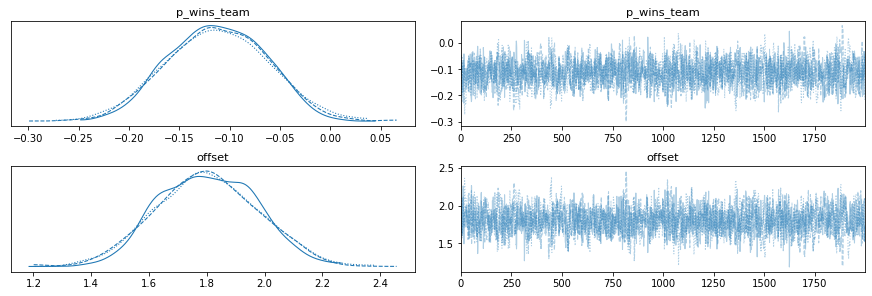

             mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
p_wins_team -0.11  0.05   -0.20    -0.02        0.0      0.0   1476.82   
offset       1.80  0.18    1.49     2.13        0.0      0.0   1406.03   

              ess_sd  ess_bulk  ess_tail  r_hat  
p_wins_team  1476.82   1460.01   1437.62    1.0  
offset       1406.03   1394.80   1828.32    1.0  


In [47]:
gauss = GaussianModel(wins_team=wins_of_team_in_last_five[100:304],
                      bets=bets_of_team[100:304])
gauss.run()

In [48]:
mean_wins_team = gauss.trace["p_wins_team"].mean()
mean_offset = gauss.trace["offset"].mean()
print(bets_of_team[49])
bet = mean_wins_team * wins_of_team_in_last_five[49] +\
      mean_offset
print(bet)

error = 0
for i, value in enumerate(enemies_of_team[0:99]):
    bet = mean_wins_team * wins_of_team_in_last_five[i] +\
      mean_offset
    error += abs(bet - bets_of_team[i])
avg_error = error / 100
print(avg_error)

4.0
1.8022659070352187
0.4354928845687197
